In [98]:
from dependencies import *
from save_data import *
from defaults import *

In [99]:
# helper function to get differences in cooling between analogous model runs
def get_min_diffs(filenames,print_progress=True,plot=True):
    def get_min_temps(filename):
        with Dataset(filename, "r") as ds:
            min_T = ds.groups['stats'].variables['min_temp'][:]
        return min_T
    
    if print_progress:
        print("Fetching data for",filenames[0][5:-3])
    min_T1 = get_min_temps(filenames[0])
    if print_progress:
        print("Fetching data for",filenames[1][5:-3])
    min_T2 = get_min_temps(filenames[1])
    
    T_diffs = min_T1-min_T2
    
    if print_progress:
        if np.nanmean(T_diffs) > 0:
            print(filenames[1][5:-3],"cools more than",filenames[0][5:-3])
        elif np.nanmean(T_diffs) < 0:
            print(filenames[0][5:-3],"cools more than",filenames[1][5:-3])
        print(f'Mean difference: {np.nanmean(T_diffs):0.2f} K')
    
    if plot:
        fig,ax = plt.subplots()
        ax.hist(T_diffs,bins=500)
        ax.set_xlabel('Temp. diff. (K)')
        ax.set_ylabel('Frequency')
        return ax

In [100]:
# files to fetch
iters = 10_000
iter_str = str(iters) if iters < 1000 else f"{int(iters/1000)}k"

Fetching data for CAMP_10k
Fetching data for CAMP_nodegass_10k
CAMP_nodegass_10k cools more than CAMP_10k
Mean difference: 0.48 K


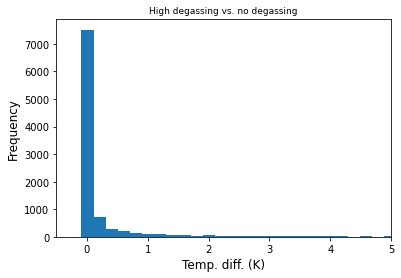

In [101]:
# degassing comparison
filenames_degass = [f"data/CAMP_{iter_str}.nc", f"data/CAMP_nodegass_{iter_str}.nc"]
ax = get_min_diffs(filenames_degass)

ax.set_title("High degassing vs. no degassing")
ax.set_xlim(-0.5,5)
plt.show()

Fetching data for CAMP_EP0_10k
Fetching data for CAMP_EP1_10k
CAMP_EP1_10k cools more than CAMP_EP0_10k
Mean difference: 8.04 K


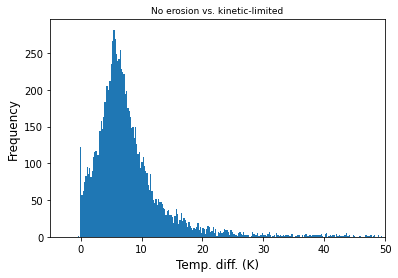

In [102]:
# erosion comparison
filenames_erosion = [f"data/CAMP_EP0_{iter_str}.nc", f"data/CAMP_EP1_{iter_str}.nc"]
ax = get_min_diffs(filenames_erosion)

ax.set_title("No erosion vs. kinetic-limited")
ax.set_xlim(-5,50)
plt.show()

In [93]:
# helper function to plot probability distributions
def plot_temp_density(filenames, custom_labels=None, figname=None,
                      normed=False, threshold=280,
                      hist=False, kdeplot=True, fill=False,
                      extra_labels=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,2.5))
    
    for i, filename in enumerate(filenames):
        # fetch data for each file
        with Dataset(filename, "r") as ds:
            if not normed:
                min_T = ds.groups['stats'].variables['min_temp'][:]
            else:
                min_T = ds.groups['stats'].variables['min_normed_temp'][:]
        
        # filter out nans
        min_T = min_T[~np.isnan(min_T)]
        
        # plot histogram if specified
        if hist:
            ax.hist(min_T, bins=100, density=True, alpha=0.3, histtype='step',
                    label='binned data' if hist and kdeplot and extra_labels else None)
        
        linestyle = '-' if i == 0 else '--'  # solid line for first file, dashed for others
        
        # plot KDE if specified
        if kdeplot:
            kde = sns.kdeplot(min_T, ax=ax, bw_adjust=0.2 if normed else 1,
                              clip=(min_T.min(), min_T.max()),
                              label=custom_labels[i] if custom_labels else f'File {i+1}',
                              linestyle=linestyle, color='black')
            
            if fill:
                x_values = np.array(kde.get_lines()[0].get_xdata())
                y_values = np.array(kde.get_lines()[0].get_ydata())
                ax.fill_between(x_values, y_values, where=(x_values <= threshold),
                                color='cadetblue', alpha=0.3)
    
    # Set plot limits and labels
    ax.set_xlim(245, 290) if not normed else ax.set_xlim(-40, 10)
    if threshold and threshold > ax.get_xlim()[0] and threshold < ax.get_xlim()[1]:
        ax.axvline(threshold, color='cadetblue', label='Snowball threshold')
        
    #ax.set_xlabel('Minimum temperature (K) within 2.15 Myr') if not normed else ax.set_xlabel('Min. temperature anomaly ($\Delta$K) within 2.15 Myr')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.legend(loc='upper left', frameon=False)
    
    if figname and ax is None:
        plt.tight_layout()
        plt.savefig(figname + ".png", format='png', bbox_inches='tight', dpi=600)
        plt.show()

In [94]:
plt.rcParams.update({'legend.fontsize': 7,
                     'font.size': 9,
                     'lines.linewidth': 1,
                     'axes.titlesize': 9})

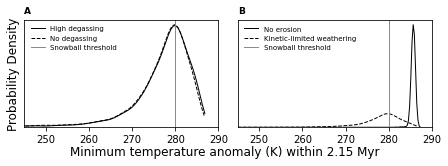

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(6.3,2.5))

# degassing
ax = axs[0]
ax.set_title('A', loc='left', fontweight='bold')
filenames = filenames_degass
custom_labels = ["High degassing",
                 "No degassing"]
plot_temp_density(filenames=filenames,custom_labels=custom_labels,ax=ax)

# erosion/topography
ax = axs[1]
ax.set_title('B', loc='left', fontweight='bold')
filenames = filenames_erosion
custom_labels = ["No erosion", # E$_0$/P$_0$=0
                 "Kinetic-limited weathering" # E$_0$/P$_0$=1
                ]
plot_temp_density(filenames=filenames,custom_labels=custom_labels,ax=ax)

# formatting
fig.supxlabel('Minimum temperature anomaly (K) within 2.15 Myr',y=0.1,fontsize=12)
axs[0].set_ylabel('Probability Density')
    
plt.tight_layout()
plt.savefig('figs/CAMP'+'.jpg',format='jpg',bbox_inches='tight', dpi=600)
plt.show()